In [33]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [34]:
IMAGE_SIZE = 512
BATCH_SIZE = 32
CHANNELS =3
EPOCHS = 50

In [35]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "dataset",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 100 files belonging to 4 classes.


In [36]:
class_names = dataset.class_names
class_names

['chargement_citerne',
 'chargement_remorque',
 'déchargement_citerne',
 'déchargement_remorque']

In [37]:
len(dataset)

4

In [38]:
for image_batch,label_batch in dataset.take(1):
        print(image_batch.shape)
        print(label_batch.numpy())

(32, 512, 512, 3)
[0 1 2 0 1 0 0 1 2 1 0 2 1 0 1 3 3 0 3 3 3 3 2 3 3 0 3 3 0 2 3 3]


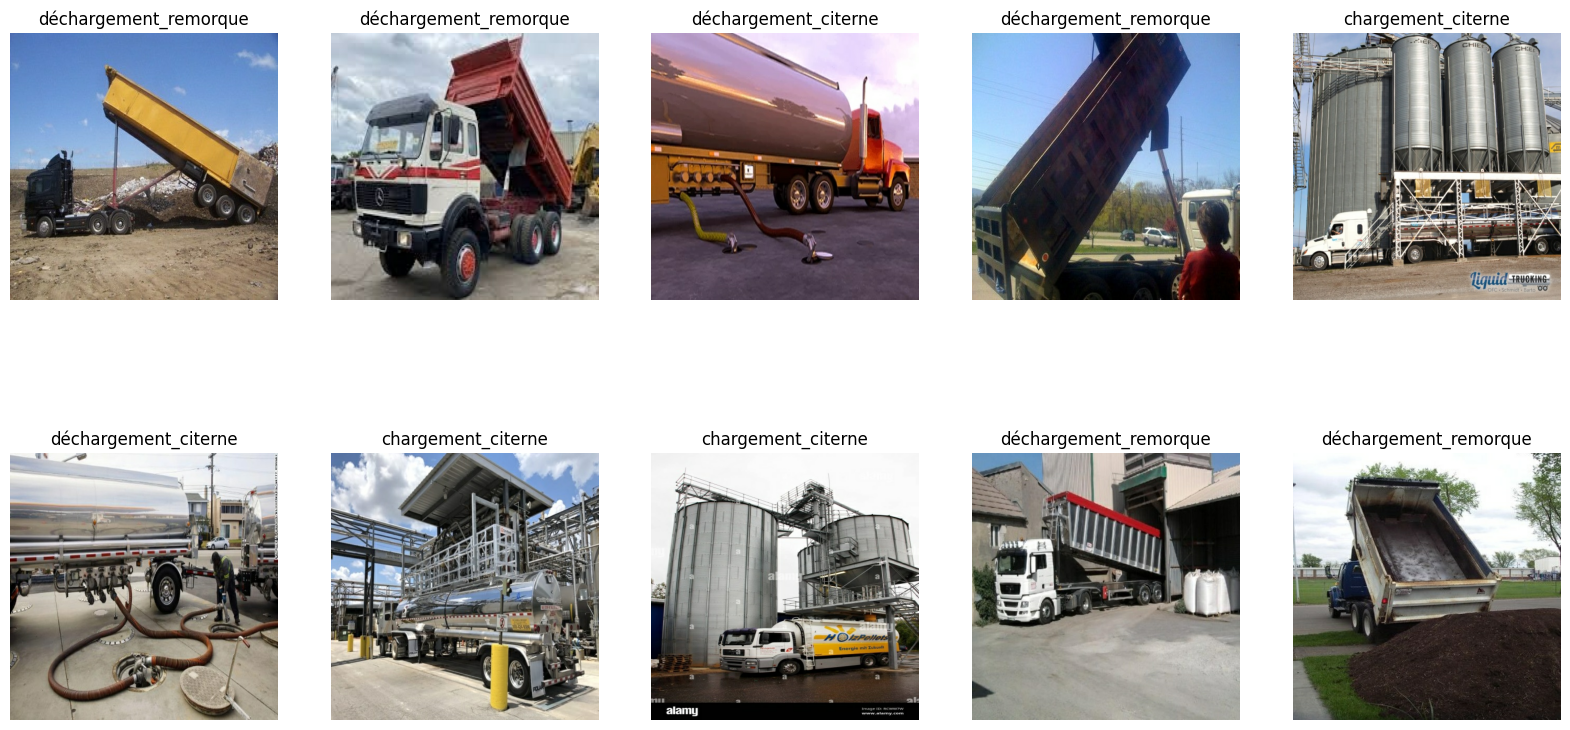

In [39]:
plt.figure(figsize=(20,10))
for image_batch,label_batch in dataset.take(1):
    for i in range(10):
        ax = plt.subplot(2,5, i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.axis("off")
        plt.title(class_names[label_batch[i]])

Split Dataset

In [40]:
def get_dataset_partitions_tf(ds, train_split=0.7, val_split=0.2, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [41]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [42]:
len(train_ds),len(test_ds),len(val_ds)

(2, 2, 0)

Cache, Shuffle, and Prefetch the Dataset

In [43]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

Creating a Layer for Resizing and Normalization

In [44]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

DATA AUGMENTATION

In [45]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

Applying Data Augmentation to Train Dataset

In [46]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

Model Architecture

In [47]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 4

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [48]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (32, 512, 512, 3)         0         
                                                                 
 conv2d_6 (Conv2D)           (32, 510, 510, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPooling  (32, 255, 255, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (32, 253, 253, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (32, 126, 126, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (32, 124, 124, 64)       

COMPILING THE MODEL

In [49]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [50]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/50
2/2 [==============================] - 20s 16s/step - loss: 1.3641 - accuracy: 0.3611
Epoch 2/50
2/2 [==============================] - 8s 852ms/step - loss: 1.3186 - accuracy: 0.4167
Epoch 3/50
2/2 [==============================] - 8s 7s/step - loss: 1.3870 - accuracy: 0.4167
Epoch 4/50
2/2 [==============================] - 8s 883ms/step - loss: 1.3518 - accuracy: 0.4167
Epoch 5/50
2/2 [==============================] - 8s 987ms/step - loss: 1.3450 - accuracy: 0.4167
Epoch 6/50
2/2 [==============================] - 7s 6s/step - loss: 1.3723 - accuracy: 0.4167
Epoch 7/50
2/2 [==============================] - 7s 6s/step - loss: 1.3883 - accuracy: 0.4167
Epoch 8/50
2/2 [==============================] - 7s 822ms/step - loss: 1.3498 - accuracy: 0.4167
Epoch 9/50
2/2 [==============================] - 8s 7s/step - loss: 1.3317 - accuracy: 0.4167
Epoch 10/50
2/2 [==============================] - 8s 7s/step - loss: 1.3263 - accuracy: 0.4167
Epoch 11/50
2/2 [==================

In [25]:
scores = model.evaluate(test_ds)

2/2 [==============================] - 7s 2s/step - loss: 3.8411 - accuracy: 0.5000


In [23]:
scores

[0.28643369674682617, 0.890625]

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

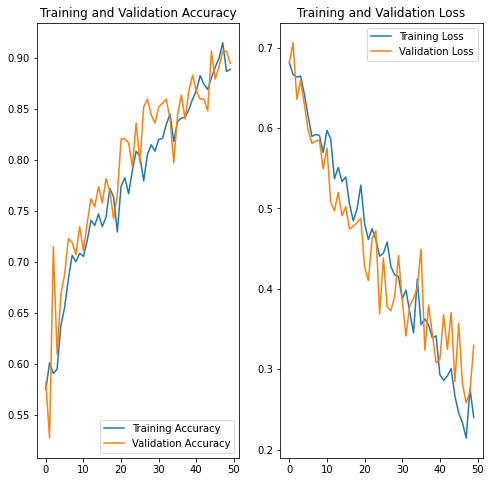

In [25]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: tank_truck
1/1 [==============================] - 2s 2s/step
predicted label: tank_truck


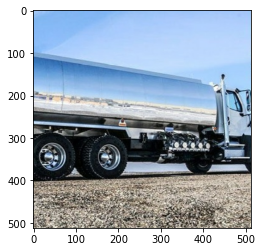

In [26]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

function for inference

In [27]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

run inference on few sample images

1/1 [==============================] - 0s 85ms/step


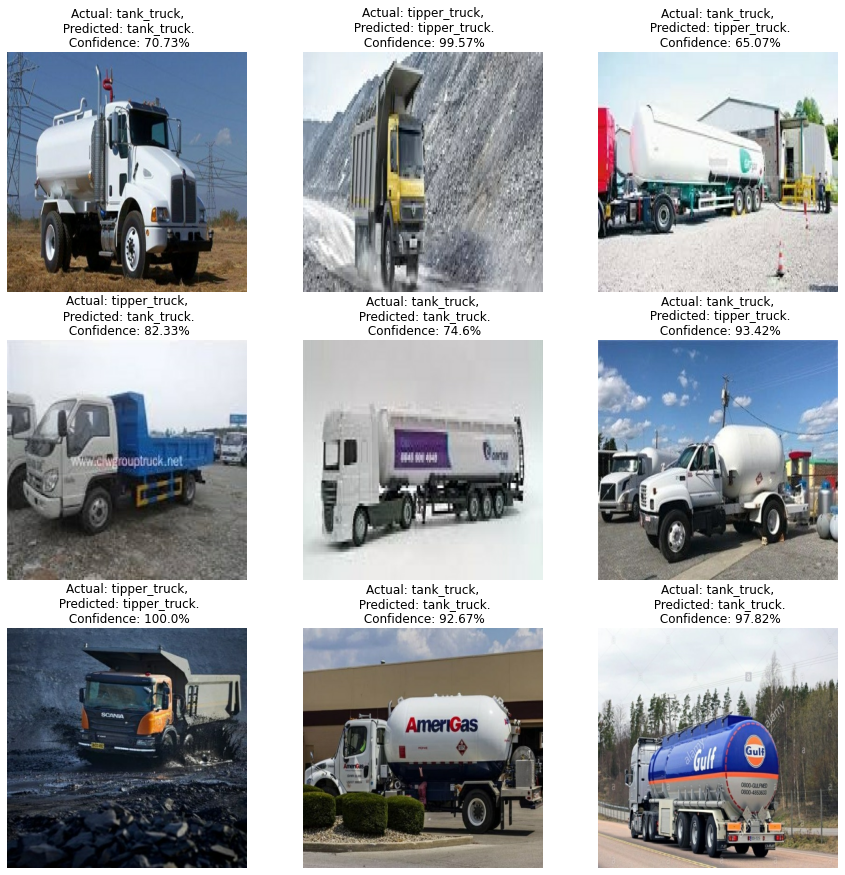

In [28]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

Saving the Model

In [30]:
import os
model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/1\assets


INFO:tensorflow:Assets written to: ../models/1\assets


In [31]:
model.save("../trucks.h5")